In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import numpy as np
import torch
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.cuda.manual_seed_all

dtype = torch.float
device = torch.device("cuda:0")


In [2]:
import sys

In [3]:
sys.path.append('/u/wangnisn/devel/machine_learning_kinetics/ml_kinetics')

In [4]:
from mlk import learning

# Set up model

In [5]:
vortex = {'eqn_type':'vortex',
        'fcn':'exp(-1/2*(x-cos(t))**2-1/2*(y-sin(t))**2)',
        'domain':{'x':[-2,2],'y':[-2,2],'t':[0,2]},
        
        'err_vec':[0,0,0,1,-1,0,0]}

u_t,u_x,u_y,u,x,y = sympy.symbols('u_t u_x u_y u x y')

dictionary = (u_x,u_y,x*u_x,y*u_x,x*u_y,y*u_y,u)
vortex['dictionary'] = dictionary
pde = vortex
domain =pde['domain']
fcn = pde['fcn']
n_points = 50000
x = sympy.symbols([x for x in domain.keys()])
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
inputs = {}
for key in domain.keys():
    min_d = domain[key][0]
    max_d = domain[key][1]
    #iputs[key] = ((max_d-min_d)*torch.rand((n_points,1),device=device,dtype=dtype,requires_grad=True)+min_d)
    tt = np.random.uniform(min_d,max_d,(n_points,1))
    inputs[key] = torch.tensor(tt,device=device,dtype=dtype,requires_grad=True)
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
u = u_exact(*[i.detach().cpu() for i in inputs.values()])
pde = {}
u = u.type(dtype).to(device)
pde['inputs'] = inputs

In [6]:
params = {'n_epochs':10000,
          'alpha_pde_start':1,
           'alpha_pde_end':1,
           'alpha_l1':1e-5, 
           'batch_size':50000,
          'warmup_nsteps':500,
          'linearRegInterval':5,
          'linearRegression':True,
          'width':50,
          'layers':8,
          'lr':0.002,
          'update_coef_in_dl':False,
          'logfile':'fixed_alpha.txt'}

model = learning(inputs=inputs, u=u, dictionary=dictionary,**params)


Epoch:    0,  Loss u: 1.385e-01, Loss pde: 9.828e-04, Loss_norm: 7.488e+00, Loss tot: 1.385e-01
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:   50,  Loss u: 1.590e-02, Loss pde: 3.425e-01, Loss_norm: 7.488e+00, Loss tot: 1.590e-02
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  100,  Loss u: 2.286e-03, Loss pde: 8.929e-01, Loss_norm: 7.488e+00, Loss tot: 2.286e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  150,  Loss u: 2.072e-03, Loss pde: 9.717e-01, Loss_norm: 7.488e+00, Loss tot: 2.072e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  200,  Loss u: 1.441e-03, Loss pde: 9.003e-01, Loss_norm: 7.488e+00, Loss tot: 1.441e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00  

Epoch: 2050,  Loss u: 3.814e-05, Loss pde: 5.013e-05, Loss_norm: 1.929e+00, Loss tot: 1.076e-04
  coefs:  1.1504e-01   -7.2107e-02   -1.8464e-03    8.6863e-01   -8.6867e-01   -0.0000e+00   -2.6300e-03  
Epoch: 2100,  Loss u: 3.600e-05, Loss pde: 4.822e-05, Loss_norm: 1.929e+00, Loss tot: 1.035e-04
  coefs:  1.0483e-01   -6.3134e-02   -1.3637e-03    8.8115e-01   -8.8144e-01   -7.6575e-04   -2.2660e-03  
Epoch: 2150,  Loss u: 3.967e-05, Loss pde: 4.841e-05, Loss_norm: 1.933e+00, Loss tot: 1.074e-04
  coefs:  9.7483e-02   -6.1706e-02   -4.5430e-04    8.9125e-01   -8.9231e-01   -1.8507e-04   -1.9074e-03  
Epoch: 2200,  Loss u: 1.492e-04, Loss pde: 7.076e-05, Loss_norm: 1.933e+00, Loss tot: 2.393e-04
  coefs:  1.0452e-01   -4.2706e-02   -3.9542e-03    9.0080e-01   -9.0045e-01   -5.5587e-03   -5.2079e-03  
Epoch: 2250,  Loss u: 6.420e-05, Loss pde: 7.478e-05, Loss_norm: 1.982e+00, Loss tot: 1.588e-04
  coefs:  9.4503e-02   -8.9039e-02   -1.2576e-03    8.8542e-01   -9.0286e-01    7.4616e-03  

Epoch: 4100,  Loss u: 2.292e-05, Loss pde: 1.182e-05, Loss_norm: 1.957e+00, Loss tot: 5.431e-05
  coefs:  1.2253e-02   -1.1640e-02   -3.5693e-04    9.6843e-01   -9.6869e-01    0.0000e+00   -2.1272e-04  
Epoch: 4150,  Loss u: 6.320e-05, Loss pde: 3.706e-05, Loss_norm: 1.949e+00, Loss tot: 1.197e-04
  coefs:  2.3940e-06   -8.8599e-03   -7.8311e-05    9.6628e-01   -9.6737e-01    0.0000e+00    2.3849e-05  
Epoch: 4200,  Loss u: 4.585e-05, Loss pde: 2.032e-05, Loss_norm: 2.020e+00, Loss tot: 8.638e-05
  coefs:  2.9481e-02   -2.8201e-02    6.7455e-04    9.7111e-01   -9.7753e-01    2.1142e-03    1.7734e-05  
Epoch: 4250,  Loss u: 2.163e-05, Loss pde: 2.065e-05, Loss_norm: 1.952e+00, Loss tot: 6.180e-05
  coefs:  9.7440e-03   -2.3147e-03   -1.0040e-03    9.6822e-01   -9.7001e-01   -1.5418e-03   -0.0000e+00  
Epoch: 4300,  Loss u: 1.235e-04, Loss pde: 1.213e-04, Loss_norm: 2.020e+00, Loss tot: 2.650e-04
  coefs:  5.9457e-03   -5.5241e-02    5.3146e-03    9.6886e-01   -9.7921e-01    6.1987e-03  

Epoch: 6150,  Loss u: 6.288e-05, Loss pde: 2.884e-05, Loss_norm: 2.017e+00, Loss tot: 1.119e-04
  coefs:  1.6394e-02   -1.5728e-02    4.7944e-03    9.9272e-01   -9.9902e-01   -1.6941e-03    1.7314e-04  
Epoch: 6200,  Loss u: 3.709e-05, Loss pde: 1.116e-05, Loss_norm: 1.988e+00, Loss tot: 6.813e-05
  coefs:  1.1092e-02   -2.1645e-02    6.5890e-04    9.6867e-01   -9.7785e-01    1.4641e-03    6.1684e-04  
Epoch: 6250,  Loss u: 2.710e-05, Loss pde: 2.248e-05, Loss_norm: 1.986e+00, Loss tot: 6.945e-05
  coefs:  1.5147e-02    7.5540e-03   -2.1349e-03    9.8392e-01   -9.8304e-01   -2.7409e-03   -0.0000e+00  
Epoch: 6300,  Loss u: 1.886e-05, Loss pde: 9.582e-06, Loss_norm: 1.979e+00, Loss tot: 4.823e-05
  coefs:  9.2649e-03    3.6809e-03    2.9200e-03    9.8745e-01   -9.6947e-01   -1.8753e-03   -8.2476e-04  
Epoch: 6350,  Loss u: 4.191e-05, Loss pde: 1.690e-05, Loss_norm: 1.973e+00, Loss tot: 7.853e-05
  coefs:  8.0409e-03   -9.9055e-03   -1.8679e-03    9.7101e-01   -9.7460e-01    3.2055e-03  

Epoch: 8200,  Loss u: 7.308e-06, Loss pde: 7.339e-06, Loss_norm: 1.992e+00, Loss tot: 3.457e-05
  coefs:  1.3268e-02   -1.4336e-02   -2.3594e-03    9.7858e-01   -9.8268e-01    5.2545e-03   -1.4480e-04  
Epoch: 8250,  Loss u: 1.425e-04, Loss pde: 1.588e-05, Loss_norm: 1.979e+00, Loss tot: 1.781e-04
  coefs:  1.9327e-02   -1.1838e-02   -6.2493e-03    9.7066e-01   -9.8339e-01    4.0556e-03    4.5330e-05  
Epoch: 8300,  Loss u: 7.316e-05, Loss pde: 1.664e-05, Loss_norm: 1.998e+00, Loss tot: 1.098e-04
  coefs:  6.6768e-03   -5.1002e-03    5.5529e-03    9.9430e-01   -9.9325e-01   -2.5189e-03   -6.4827e-04  
Epoch: 8350,  Loss u: 3.440e-06, Loss pde: 4.440e-06, Loss_norm: 1.989e+00, Loss tot: 2.777e-05
  coefs:  1.0275e-02   -7.1806e-03    2.2055e-04    9.8485e-01   -9.8628e-01    1.1394e-05   -4.8893e-05  
Epoch: 8400,  Loss u: 3.251e-06, Loss pde: 4.235e-06, Loss_norm: 1.992e+00, Loss tot: 2.740e-05
  coefs:  1.1916e-02   -7.6777e-03    2.1482e-04    9.8556e-01   -9.8653e-01   -0.0000e+00  

In [13]:
log = pd.read_csv('fixed_alpha.txt')

(-1.0, 1.0)

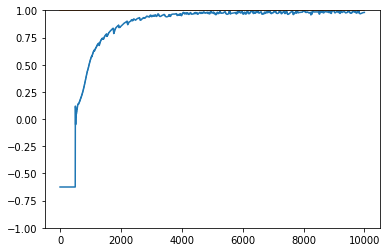

In [14]:
plt.plot(log['Epoch'].values, log['p3'].values)
plt.plot([0,10000],[1,1])
plt.ylim(-1,1)

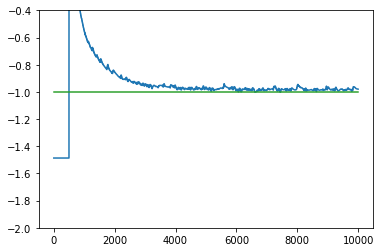

In [15]:
plt.plot(log['Epoch'], log['p4'])
plt.plot([0,10000],[1,1])
plt.ylim(-2,-0.4)
plt.plot([0,10000],[-1,-1])

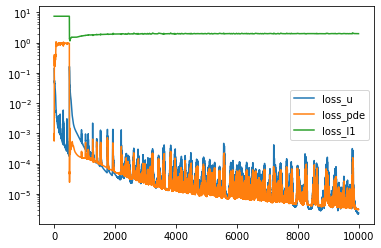

In [16]:
plt.semilogy(log['Epoch'], log['Loss_u'], label='loss_u')
plt.semilogy(log['Epoch'], log['Loss_pde'], label='loss_pde')
plt.semilogy(log['Epoch'], log['Loss_l1'], label='loss_l1')
plt.legend()

In [12]:
t_mesh = dt*np.arange(nsteps)
x_mesh = dx*np.arange(nx)
y_mesh = dy*np.arange(ny)
t_mesh, x_mesh,y_mesh = np.meshgrid(t_mesh, x_mesh, y_mesh,indexing='ij')
t_mesh = np.reshape(t_mesh, (-1,1))
x_mesh = np.reshape(x_mesh, (-1,1))
y_mesh = np.reshape(y_mesh, (-1,1))
x_mesh /= x_max
y_mesh /= y_max
t_mesh /= t_max
prediction = model(torch.cat([torch.tensor(x_mesh), torch.tensor(y_mesh), torch.tensor(t_mesh)],dim=1).double().cuda(0))

NameError: name 'dt' is not defined